## Group Names: Angus Martin, Konrad Ochedzan, Oscar Romero Alarcon, Christopher Yuan 


# **Question 1**
In this section we import and format the data appropriately

In [ ]:
#For Question 1, you can import the following packages:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

## **Part a**
Import the dataset Housing.csv in Python as a pandas DataFrame

In [ ]:
# Used for Google Colab Notebook
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
Housing = pd.read_csv('sample_data/Housing.csv')
Housing.set_index('Id', inplace=True)

## **Part b**
To assess the normality of the target variable, SalePrice, we examine both a histogram of the data and a QQ-plot against a theoretical Gaussian distribution.

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

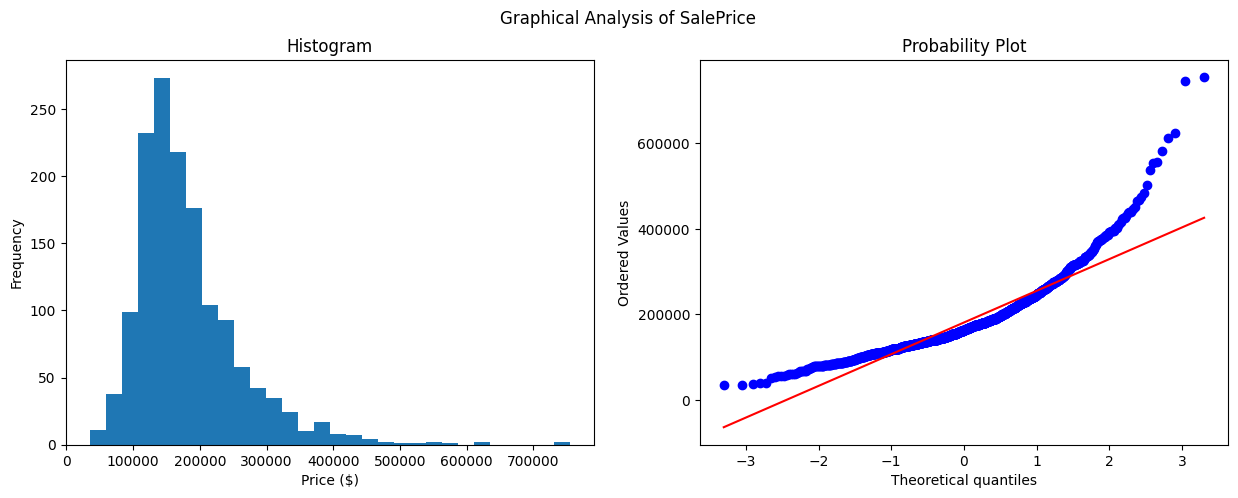

In [ ]:
targets = Housing['SalePrice']
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Graphical Analysis of SalePrice')

axs[0].set_title('Histogram')
axs[0].hist(targets, bins=30)
axs[0].set_xlabel('Price ($)')
axs[0].set_ylabel('Frequency')

stats.probplot(targets, dist="norm", plot=axs[1])

It is clear from both the histogram and QQ-plot that the distribution of SalePrice deviates heavily from a Gaussian distribution. In particular, this can be seen in the QQ-plot where the ordered vallues of the target variable show a pronounced trend away from the plotted normal (red line). We see this as well in the skewed distribution of the histogram.

To combat this, we attempt to normalize the target using the Box-Cox transformation which is a standard method to make a random variable more "Gaussian-like." In particular, the transformation is represented by

$$y^{(\lambda)} = \begin{cases} \frac{y^\lambda - 1}{\lambda},\; \lambda \ne 0 \\ \log y,\; \lambda = 0 \end{cases}$$

where $\lambda$ is a fit parameter that is estimated according to the data profile. Now we use the boxcox function into stats package to get the optimal lambda for this transformation (that is the one maximizing log likelihood function).

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([7.18570004, 7.19093392, 7.22246524, ..., 8.34295629, 8.40544945,
         8.41015936])),
 (0.1578107006095664, 7.8422494667956375, 0.9955315706104014))

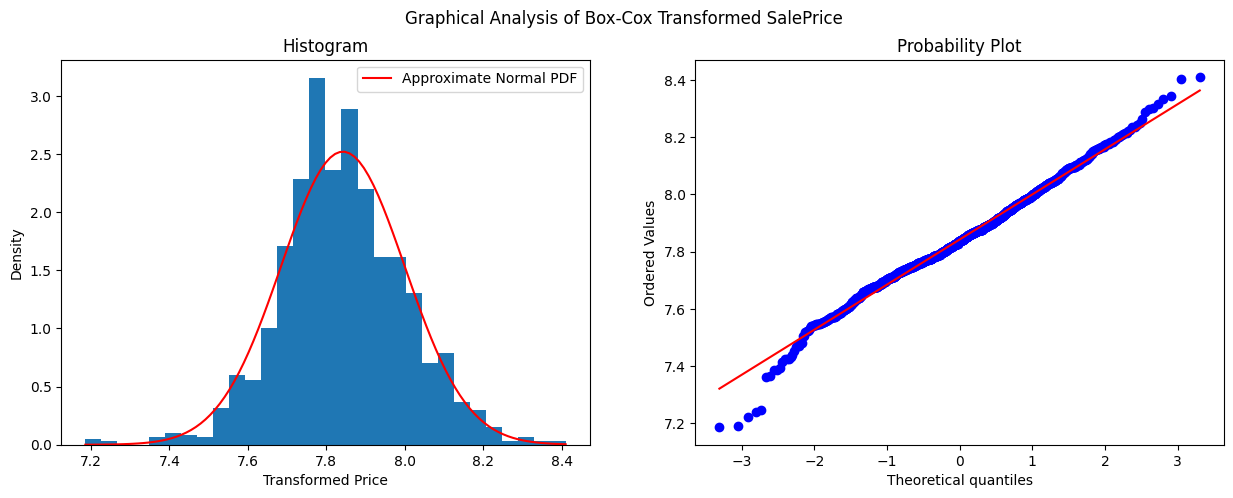

In [ ]:
boxcox_target, estimated_lambda = stats.boxcox(targets)

y_mean, y_std = np.mean(boxcox_target), np.std(boxcox_target)
y_min, y_max = np.min(boxcox_target), np.max(boxcox_target)
y_range = np.linspace(y_min, y_max, 101)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Graphical Analysis of Box-Cox Transformed SalePrice')

axs[0].set_title('Histogram')
axs[0].hist(boxcox_target, bins=30, density=True)
axs[0].plot(y_range, stats.norm.pdf(y_range, y_mean, y_std), color='r', label="Approximate Normal PDF")
axs[0].set_xlabel('Transformed Price')
axs[0].set_ylabel('Density')
axs[0].legend()

stats.probplot(boxcox_target, dist="norm", plot=axs[1])

In [ ]:
print(f"Estimated fit parameter, 𝜆, of Box-Cox transformation: {estimated_lambda:.3f}")

Estimated fit parameter, 𝜆, of Box-Cox transformation: -0.077


We can see from the plots of the transformed data that the Box-Cox method has done its job to successfully make the SalePrice data "more normal." In particular, the Box-Cox method has estimated a $\lambda$ of $-0.077$, which we take as approximately $0$ up to statistical significance. For simplicity, then, going forward we will just use a log-transformation to normalize the target variable. The result of this transformation on SalePrice can be seen below.


((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.3982622308161888, 12.024050901109383, 0.9953761475636613))

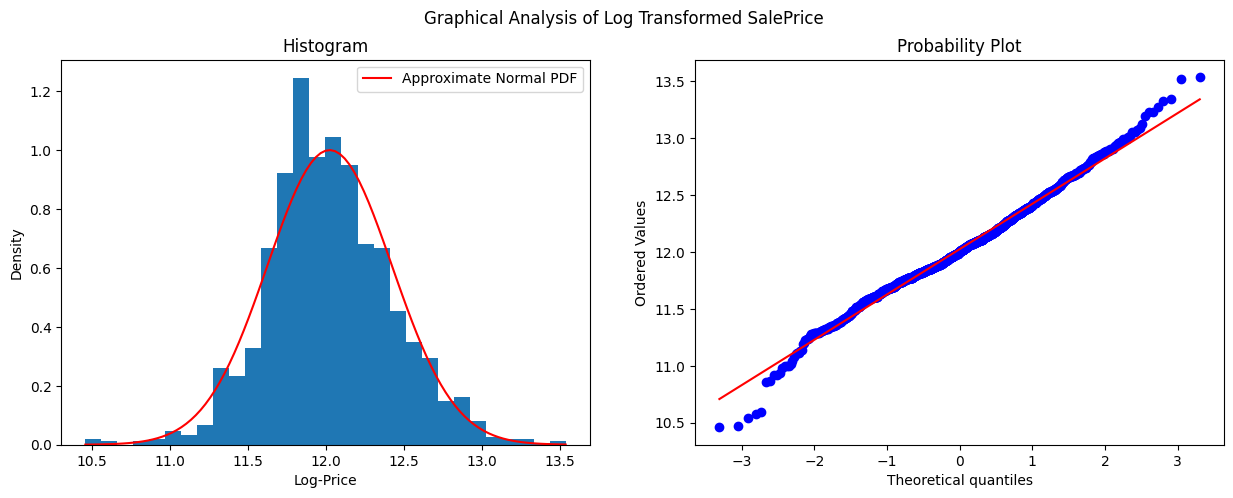

In [ ]:
# Applying a straight-forward log transformation to the target variable
logged_target = np.log(Housing['SalePrice'])
Housing['TransformedSalePrice'] = logged_target

# Fitting a normal distribution to the transformed data
y_mean, y_std = np.mean(logged_target), np.std(logged_target)
y_min, y_max = np.min(logged_target), np.max(logged_target)
y_range = np.linspace(y_min, y_max, 101)


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Graphical Analysis of Log Transformed SalePrice')

axs[0].set_title('Histogram')
axs[0].hist(logged_target, bins=30, density=True)
axs[0].plot(y_range, stats.norm.pdf(y_range, y_mean, y_std), color='r', label="Approximate Normal PDF")
axs[0].set_xlabel('Log-Price')
axs[0].set_ylabel('Density')
axs[0].legend()

stats.probplot(logged_target, dist="norm", plot=axs[1])

In [ ]:
# Shapiro-Wilk test to test for normality
stats.shapiro(Housing["TransformedSalePrice"])

ShapiroResult(statistic=0.9912067503807811, pvalue=1.1490615527264654e-07)

The result of the Shapiro test above tests the null hypothesis for the data being normally distributed. Although the p-value is quite low and therefore the data is probably not truly Gaussian, for the purposes of this project this transformation will suffice. In particular, we see that the log transformation has eliminated the skew in the histogram as well as the strong curve in the QQ-plot. We are left now with only relatively minor deviations in the QQ-plot at the tail ends.

## **Part c**
Here we handle missing data from the table. This includes filling NA values with 1) the mean in numerical columns, or 2) the mode in the case of categorical variables where "NA" is not a valid option (that is taking into consideration the fact that some columns has "NA" as a category usually meaning a given thing did not appear, not that it wasn't measured). After this we construct a new dataframe with one-hot-encoded categorical variables.

In [ ]:
# Getting columns of numerical variables
missing_vals = Housing.isna().sum().sum()
numerical_cols = Housing.select_dtypes(include=['number']).columns

# Getting columns of categorical variables
categorical_cols = Housing.select_dtypes(exclude=['number']).columns
# Partitioning categorical_cols into those with and without 'NA' categories
na_categories_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
nona_categories_cols = categorical_cols.difference(na_categories_cols)

means = Housing[numerical_cols].mean()
modes = Housing[nona_categories_cols].mode()
fillna_dict = {cat: means[cat].item() for cat in numerical_cols} | {nonacat: modes[nonacat].item() for nonacat in nona_categories_cols} | {nacat: 'NA' for nacat in na_categories_cols}

Housing.fillna(fillna_dict, inplace=True)

print(f'Missing values removed: {missing_vals}')
#Use one-hot encoding for the categorical features using the default function pd.get_dummies(...).

# One-hot-encoding
Housing_OHE = pd.get_dummies(Housing, dtype=float)

Missing values removed: 7829


## **Part d**
Here we make a subset of the full dataframe consisting only of empirical feature variables.

In [ ]:
Housing2 = Housing.copy()
Housing2 = Housing2[numerical_cols]

# **Question 2**
In this question we build a linear regression model to predict the (transformed) variable SalePrice using the DataFrame Housing2 based only on the 36 numerical variables.

In [ ]:
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

## **Part a**
To start we have to split the Housing2 data into a training set, $(\mathbf{X}, \mathbf{y})_{train}$, and a test set, $(\mathbf{X}, \mathbf{y})_{test}$. We construct the training set with 70% of the observations, and the test set with the remaining 30%. The partition is done randomly, however we will set a seed for reproducibility.

In [ ]:
# Setting random seed for reproducibility
random_seed = 213742069
# Splitting data into training and testing datasets
Housing2_train, Housing2_test = train_test_split(Housing2, test_size=0.3, random_state=random_seed)

## **Part b**
Now we fit a linear model on the training data using the sklearn package and compare the in-sample and out-of-sample Mean Squared Error (MSE) and $R^2$ of the model.

In [ ]:
y_train, X_train = Housing2_train['TransformedSalePrice'], Housing2_train.drop(['TransformedSalePrice','SalePrice'], axis=1)
y_test, X_test = Housing2_test['TransformedSalePrice'], Housing2_test.drop(['TransformedSalePrice','SalePrice'], axis=1)

Now we fit the linear regression model on the training data. Just after that we read the coefficients of obtained model.

In [ ]:
lm_2b = LinearRegression()
lm_2b.fit(X_train, y_train)
coef = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lm_2b.coef_})
print(coef)

          Feature   Coefficient
0      MSSubClass -6.584006e-04
1     LotFrontage -3.073070e-04
2         LotArea  1.959020e-06
3     OverallQual  8.611914e-02
4     OverallCond  4.938682e-02
5       YearBuilt  3.263091e-03
6    YearRemodAdd  1.156543e-03
7      MasVnrArea  1.807611e-05
8      BsmtFinSF1  8.619504e-06
9      BsmtFinSF2  8.160142e-07
10      BsmtUnfSF  2.185179e-05
11    TotalBsmtSF  3.128731e-05
12       1stFlrSF  6.305275e-05
13       2ndFlrSF  4.929911e-05
14   LowQualFinSF  1.662882e-05
15      GrLivArea  1.289807e-04
16   BsmtFullBath  8.131749e-02
17   BsmtHalfBath  3.001114e-02
18       FullBath  2.779744e-02
19       HalfBath  6.441326e-03
20   BedroomAbvGr  2.055380e-03
21   KitchenAbvGr -3.288567e-02
22   TotRmsAbvGrd  1.506995e-02
23     Fireplaces  4.892440e-02
24    GarageYrBlt -4.299301e-04
25     GarageCars  7.266736e-02
26     GarageArea -9.005409e-06
27     WoodDeckSF  1.242275e-04
28    OpenPorchSF -9.936375e-05
29  EnclosedPorch  1.713428e-04
30      

To establish the quality of the model we produced we calculate MSE and $R^2$ using functions from the sklearn package.

In [ ]:
yhat_train = lm_2b.predict(X_train)
yhat_test = lm_2b.predict(X_test)
mse2b_train = mean_squared_error(y_train, yhat_train)
mse2b_test = mean_squared_error(y_test, yhat_test)
r22b_train = r2_score(y_train, yhat_train)
r22b_test = r2_score(y_test, yhat_test)

print(f'In-sample MSE: {mse2b_train:.4f}, R2: {r22b_train:.4f}')
print(f'Out-of-sample MSE: {mse2b_test:.4f}, R2: {r22b_test:.4f}')

In-sample MSE: 0.0225, R2: 0.8549
Out-of-sample MSE: 0.0188, R2: 0.8892


We see that even this simple model performs impressively well. In particular, the $R^2$ scores, as a metric of goodness-of-fit, show that the model does a very good job describing the data. Although it is peculiar that the model seems to perform better on the out-of-sample data than the training data, this difference is relatively small and could be up to the randomness of the split.

## **Part c**
To estimate the standard errors of the regressio coefficients of the model, we need to write a function with the numpy package that implements the appropriate formula.

### **c(i)**

We now want to estimate the vector of coefficients for our linear model $\boldsymbol{\hat{\beta}}$ of the coefficients. For that we first need to create the matrix $\mathbf{A}$ representing the observations of independent variables and one row responsible for taking into consideration the intercept. We then apply the formula
$$\boldsymbol{\hat{\beta}} = (\mathbf{A}^T\mathbf{A})^{-1} \mathbf{A}^T \mathbf{y}$$

In [ ]:
A = np.c_[np.ones(X_train.shape[0]), X_train]

betahat = np.linalg.inv(A.T @ A) @ A.T @ y_train

### **c(ii)**

We estimate the standard error of our predicted coefficients, $\boldsymbol{\hat{\beta}}$, according to

$$\text{SE}(\hat{\beta_j}) = \sqrt{\frac{\sum_{i=1}^{m}(y_i - \hat{y_i})^2}{m - d - 1}a_j}$$

Where $a_j$ is the j-th element of the diagonal of $(\mathbf{A}^T\mathbf{A})^{-1}$.

In [ ]:
# Function to calculate the standard error of our estimate according to formual given
def betahat_std(beta_est, X, y, cov_diag):
    (m, d_aug) = X.shape
    yhat = X @ beta_est

    var_vector = np.linalg.norm(yhat - y, 2)**2 * cov_diag / (m - d_aug)

    return np.sqrt(var_vector)

cov_diag = np.diag(np.linalg.inv(A.T @ A))
betahat_se = betahat_std(betahat, A, y_train, cov_diag)
print(betahat_se)

[2.20494844e+04 4.26724739e-01 7.79961958e-01 1.63669110e-03
 1.91433771e+01 1.66674305e+01 1.11377204e+00 1.09793858e+00
 9.22781426e-02 2.02112594e+06 2.01746282e+06 2.02432574e+06
 2.01868460e+06 2.10025536e+06 2.10025536e+06 2.10025536e+06
 2.10025536e+06 4.17087747e+01 6.43350727e+01 4.42618525e+01
 4.19116551e+01 2.72486878e+01 8.09253541e+01 1.94861172e+01
 2.76086703e+01 1.13558023e+00 4.60488861e+01 1.58728917e-01
 1.26125694e-01 2.39139862e-01 2.64096290e-01 5.69818820e-01
 2.62259795e-01 3.31614304e-01 2.49024504e-02 5.36444516e+00
 1.09603201e+01]


### **c(iii)**
We compute the (in-sample) MSE and $R^2$ using the numpy package.

In [ ]:
def mse(yhat, y):
    return np.mean((yhat - y)**2)

def r2(yhat, y):
    return 1 - np.sum((y - yhat)**2) / np.sum((y - np.mean(y))**2)

yhat_train = A @ betahat
mse_is = mse(yhat_train, y_train)
r2_is = r2(yhat_train, y_train)

print(f'In-sample MSE: {mse_is:.4f}, R2: {r2_is:.4f}')

In-sample MSE: 199433.3882, R2: -1287003.3174


The absurdly low $R^2$ is likely the result of instability in inverting the $(\mathbf{A}^T\mathbf{A})$ matrix. In fact if we take a look at the eigenvalues of this matrix we can see that it has eigenvalue that is almost zero. This can make the matrix ill-conditioned.

In [ ]:
min(np.linalg.eig(A.T @ A)[0])

-1.2176442315370675e-08

That's why it is smarter to use pseudoinverse to build this model as this process will truncate the smaller eigenvalues to simplify the inversion.

### **c(iv)**

In [ ]:
# Now we use the pseudoinverse to compute the linear model coefficients
betahat_pinv = np.linalg.pinv(A.T @ A) @ A.T @ y_train

# Displaying coefficients
betahat_pinv

array([ 2.13959713e+01, -6.58400919e-04, -3.07306683e-04,  1.95901914e-06,
        8.61191561e-02,  4.93868159e-02,  3.26308943e-03,  1.15654339e-03,
        1.80761232e-05,  8.61946792e-06,  8.16042720e-07,  2.18517533e-05,
        3.12873620e-05,  6.30526834e-05,  4.92990778e-05,  1.66285581e-05,
        1.28980688e-04,  8.13175413e-02,  3.00110856e-02,  2.77975102e-02,
        6.44134457e-03,  2.05537987e-03, -3.28856143e-02,  1.50699298e-02,
        4.89243932e-02, -4.29930114e-04,  7.26673378e-02, -9.00534897e-06,
        1.24227644e-04, -9.93639551e-05,  1.71342470e-04,  3.18828019e-04,
        4.04732290e-04, -3.20553361e-04, -3.79234574e-06,  1.38214343e-03,
       -9.30333188e-03])

In [ ]:
yhat_pinv = A @ betahat_pinv
cov_diag_pinv = np.diag(np.linalg.pinv(A.T @ A))
betahat_pinv_se = betahat_std(betahat_pinv, A, y_train, cov_diag_pinv)

# Displaying standard errors
betahat_pinv_se

array([7.40331929e+00, 1.43275371e-04, 2.61876868e-04, 5.49528780e-07,
       6.42750280e-03, 5.59618894e-03, 3.73955614e-04, 3.68639410e-04,
       3.09829353e-05, 1.29414414e-05, 2.31516984e-05, 1.26996788e-05,
       1.69631690e-05, 3.33437900e-05, 3.02971151e-05, 8.05821605e-05,
       3.05850432e-05, 1.40039696e-02, 2.16008837e-02, 1.48611811e-02,
       1.40720876e-02, 9.14890900e-03, 2.71711692e-02, 6.54257987e-03,
       9.26977527e-03, 3.81277817e-04, 1.54611875e-02, 5.32941780e-05,
       4.23474531e-05, 8.02926325e-05, 8.86719034e-05, 1.91320059e-04,
       8.80552862e-05, 1.11341480e-04, 8.36114586e-06, 1.80114488e-03,
       3.68002897e-03])

In [ ]:
mse_pinv_is = mse(yhat_pinv, y_train)
r2_pinv_is = r2(yhat_pinv, y_train)

print(f'In-sample MSE from pseudoinverse model: {mse_pinv_is:.4f}, R2: {r2_pinv_is:.4f}')

In-sample MSE from pseudoinverse model: 0.0225, R2: 0.8549


As expected, the pseudoinverse yields a superior model (lower MSE and higher R2).

### **c(v)**

In [ ]:
x = sm.add_constant(X_train)

result = sm.OLS(y_train, x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     TransformedSalePrice   R-squared:                       0.855
Model:                              OLS   Adj. R-squared:                  0.850
Method:                   Least Squares   F-statistic:                     171.1
Date:                  Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                          14:07:32   Log-Likelihood:                 489.10
No. Observations:                  1022   AIC:                            -908.2
Df Residuals:                       987   BIC:                            -735.7
Df Model:                            34                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            21.3955      7.396      2.893      0.004       6.882      35.909
MSSubClass       -0.0007      0.000     -4.600      0.000      -0.001      -0.000
LotFrontage      -0.0003      0.000     -1.175      0.240      -0.001       0.000
LotArea        1.959e-06   5.49e-07      3.569      0.000    8.82e-07    3.04e-06
OverallQual       0.0861      0.006     13.412      0.000       0.074       0.099
OverallCond       0.0494      0.006      8.834      0.000       0.038       0.060
YearBuilt         0.0033      0.000      8.735      0.000       0.003       0.004
YearRemodAdd      0.0012      0.000      3.141      0.002       0.000       0.002
MasVnrArea     1.808e-05    3.1e-05      0.584      0.559   -4.27e-05    7.88e-05
BsmtFinSF1      8.62e-06   1.29e-05      0.667      0.505   -1.67e-05     3.4e-05
BsmtFinSF2      8.16e-07   2.31e-05      0.035      0.972   -4.46e-05    4.62e-05
BsmtUnfSF      2.185e-05   1.27e-05      1.723      0.085   -3.04e-06    4.67e-05
TotalBsmtSF    3.129e-05   1.69e-05      1.846      0.065   -1.96e-06    6.45e-05
1stFlrSF       6.305e-05   3.33e-05      1.893      0.059   -2.32e-06       0.000
2ndFlrSF        4.93e-05   3.03e-05      1.628      0.104   -1.01e-05       0.000
LowQualFinSF   1.663e-05   8.05e-05      0.207      0.836      -0.000       0.000
GrLivArea         0.0001   3.06e-05      4.220      0.000     6.9e-05       0.000
BsmtFullBath      0.0813      0.014      5.813      0.000       0.054       0.109
BsmtHalfBath      0.0300      0.022      1.391      0.165      -0.012       0.072
FullBath          0.0278      0.015      1.872      0.061      -0.001       0.057
HalfBath          0.0064      0.014      0.458      0.647      -0.021       0.034
BedroomAbvGr      0.0021      0.009      0.225      0.822      -0.016       0.020
KitchenAbvGr     -0.0329      0.027     -1.212      0.226      -0.086       0.020
TotRmsAbvGrd      0.0151      0.007      2.306      0.021       0.002       0.028
Fireplaces        0.0489      0.009      5.283      0.000       0.031       0.067
GarageYrBlt      -0.0004      0.000     -1.129      0.259      -0.001       0.000
GarageCars        0.0727      0.015      4.705      0.000       0.042       0.103
GarageArea    -9.005e-06   5.32e-05     -0.169      0.866      -0.000    9.55e-05
WoodDeckSF        0.0001   4.23e-05      2.937      0.003    4.12e-05       0.000
OpenPorchSF   -9.936e-05   8.02e-05     -1.239      0.216      -0.000     5.8e-05
EnclosedPorch     0.0002   8.86e-05      1.934      0.053   -2.49e-06       0.000
3SsnPorch         0.0003      0.000      1.668      0.096   -5.62e-05       0.001
ScreenPorch       0.0004    8.8e-05      4.601      0.000       0.000       0.001
PoolArea         -0.0003      0.000     -2.882      0.004      -0.001      -0.000
MiscVal       -3.792e-06   

We can see that R2 score is the same.

In [ ]:
mean_squared_error(y_train, result.predict(x))

0.022482536050042468

And then the same applies for MSE.

## **Part d**

Let's first perform a linear regression with polynomials of degree 2.

In [ ]:
# Fitting model with second-order mixed terms
poly = PolynomialFeatures(degree=2)
Xquad_train = poly.fit_transform(X_train)
Xquad_test = poly.fit_transform(X_test)
lm_quad = LinearRegression()
lm_quad.fit(Xquad_train, y_train)

# Evaluating quadratic model
yhatquad_train = lm_quad.predict(Xquad_train)
yhatquad_test = lm_quad.predict(Xquad_test)
msequad_train = mean_squared_error(y_train, yhatquad_train)
msequad_test = mean_squared_error(y_test, yhatquad_test)
r2quad_train = r2_score(y_train, yhatquad_train)
r2quad_test = r2_score(y_test, yhatquad_test)

print(f'In-sample MSE: {msequad_train:.4f}, R2: {r2quad_train:.4f}')
print(f'Out-of-sample MSE: {msequad_test:.4f}, R2: {r2quad_test:.4f}')

In-sample MSE: 0.0047, R2: 0.9694
Out-of-sample MSE: 1.5757, R2: -8.2780


These results show textbook overfitting. It performs better than the simple linear model on the training set, but much worse on the test set. If we do it with higher order polynomials the overfitting effect will only be higher. We can see it when we perform it with polynomials of order 3.

In [ ]:
# Fitting model with third-order mixed terms
cubic = PolynomialFeatures(degree=3)
Xcube_train = cubic.fit_transform(X_train)
Xcube_test = cubic.fit_transform(X_test)
lm_cube = LinearRegression()
lm_cube.fit(Xcube_train, y_train)

# Evaluating quadratic model
yhatcube_train = lm_cube.predict(Xcube_train)
yhatcube_test = lm_cube.predict(Xcube_test)
msecube_train = mean_squared_error(y_train, yhatcube_train)
msecube_test = mean_squared_error(y_test, yhatcube_test)
r2cube_train = r2_score(y_train, yhatcube_train)
r2cube_test = r2_score(y_test, yhatcube_test)

print(f'In-sample MSE: {msecube_train:.4f}, R2: {r2cube_train:.4f}')
print(f'Out-of-sample MSE: {msecube_test:.4f}, R2: {r2cube_test:.4f}')

In-sample MSE: 0.0000, R2: 1.0000
Out-of-sample MSE: 322.4423, R2: -1897.5514


As expected, the cubic model was able to describe the training set precisely due to its large number of features, but as a result had no predictive power on the out-of-sample data.

# **Question 3**

For this last section we apply a three regularized linear models on the complete dataset (including categorical data). These models are: Ridge, LASSO, and pseudo-inverse. All of these models rely on a hyperparameter ($\alpha$) which quantify how the model balances fit with regularization.

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, RepeatedKFold, KFold

## **Part a**
As a baseline we start by training a vanilla linear regression model on the complete dataset. We also partition our training data now and reserve our test data.

In [ ]:
# Partitioning the full one-hot-encoded dataset
Housing_train, Housing_test = train_test_split(Housing_OHE, test_size=0.3, random_state=random_seed)
yfull_train, Xfull_train = Housing_train['TransformedSalePrice'], Housing_train.drop(['TransformedSalePrice','SalePrice'], axis=1)
yfull_test, Xfull_test = Housing_test['TransformedSalePrice'], Housing_test.drop(['TransformedSalePrice','SalePrice'], axis=1)

# Fitting model
lm_3a = LinearRegression()
lm_3a.fit(Xfull_train, yfull_train)

# Predicting
yhat_train = lm_3a.predict(Xfull_train)
yhat_test = lm_3a.predict(Xfull_test)

# Evaluating model in-sample and out-of-sample performance
mse_is, r2_is = mean_squared_error(yfull_train, yhat_train), r2_score(yfull_train, yhat_train)
mse_os, r2_os = mean_squared_error(yfull_test, yhat_test), r2_score(yfull_test, yhat_test)

print(f'In-sample MSE: {mse_is:.4f}, R2: {r2_is:.4f}')
print(f'Out-of-sample MSE: {mse_os:.4f}, R2: {r2_os:.4f}')

In-sample MSE: 0.0084, R2: 0.9455
Out-of-sample MSE: 0.0177, R2: 0.8958


We compare these scores to those seen in 2(d) of the numerical-variables model: In-sample MSE: 0.0225, R2: 0.8549; Out-of-sample MSE: 0.0188, R2: 0.8892. The complete model outperforms the numerical-only model on all accounts, however we note that the margin of improvement is smaller in the test-set than in training-set performance.

## **Part b**
In this section we perform hyperparameter tuning of the three regularized models using 8-fold cross-validation of the training data. Namely through this process we look to estimate the optimal $\alpha$ values for the three listed models by finding the value that minimizes test-fold MSE (averaged across the 8 partitions). 8-fold cross-validation consists of partitioning the training data into 8 folds and iteratively taking one as the out-of-sample set and training on the remaining 7.

To simplify the cross-validation process we build a estimator class for the pseudoinverse model using the sklearn RegressorMixin base class.

In [ ]:
# Needed to build a class estimator for the pseudo-inverse model
from sklearn.base import BaseEstimator, RegressorMixin

# Code for pseudo-inverse regression estimator using SVD
class Pinv(RegressorMixin, BaseEstimator):
    def __init__(self, t=1e-3):
        # Threshold parameter for estimator
        self.t = t

    def fit(self, X, y, **kwargs):
        # Error-handling pattern for compatibility with cross_val_score method
        try:
            self.t = kwargs['t']
        except:
            pass
        self.X_ = X
        self.y_ = y

        # Augmenting feature matrix
        A = np.hstack([np.ones((X.shape[0],1)), X])

        # SVD
        U, S, VT = np.linalg.svd(A, full_matrices=False)
        # Thresholding and pseudo-inverting diagonal
        S_inv = np.diag([1/s if s > self.t else 0 for s in S])
        A_pinv = VT.T @ S_inv @ U.T

        # Calculating coefficients
        self.coef_ = A_pinv @ y

        self.is_fitted_ = True

    # Method to predict on data
    def predict(self, X):
        X_aug = np.hstack([np.ones((X.shape[0],1)), X])

        y_pred = X_aug @ self.coef_

        return y_pred

    # Boiler-plate method for estimator class
    def get_params(self, deep = False):
        return {'t':self.t}

We verify that the class works as expected.

In [ ]:
# We verify that the Pinv class works as expected
pinv_lm = Pinv() # We use the default threshold of 1e-3
pinv_lm.fit(Xfull_train, yfull_train)

# Evaluating the fitted model
yhat_train = pinv_lm.predict(Xfull_train)
yhat_test = pinv_lm.predict(Xfull_test)
mse_is = mean_squared_error(yfull_train, yhat_train)
mse_os = mean_squared_error(yfull_test, yhat_test)
r2_is = r2_score(yfull_train, yhat_train)
r2_os = r2_score(yfull_test, yhat_test)

print(f'In-sample MSE for Pinv model: {mse_is:.4f}, R2: {r2_is:.4f}')
print(f'Out-of-sample MSE for Pinv model: {mse_os:.4f}, R2: {r2_os:.4f}')

In-sample MSE for Pinv model: 0.0084, R2: 0.9455
Out-of-sample MSE for Pinv model: 0.0182, R2: 0.8930


The fact that we get results similar to the built-in SciPy LinearRegression() class confirms that the class is behaving as expected. We now perform our hyperparameter tuning with 8-fold cross-validation across the models.

In [ ]:
hyperparam_vals = 101
param_range = np.logspace(-3.5, 1.5, hyperparam_vals) # We optimize over a logspace (base 10)

lasso_scores, ridge_scores, pinv_scores = [], [], []
kf = KFold(n_splits=8, shuffle=True, random_state=random_seed)

for i in range(hyperparam_vals):
    param = param_range[i]

    #Lasso model
    lm_lasso = Lasso(param, fit_intercept=True)
    lasso_mses = cross_val_score(lm_lasso, Xfull_train, yfull_train, scoring='neg_mean_squared_error', cv=kf)

    lasso_scores.append(lasso_mses)

    #Ridge model
    lm_ridge = Ridge(param, fit_intercept=True)
    ridge_mses = cross_val_score(lm_ridge, Xfull_train, yfull_train, scoring='neg_mean_squared_error', cv=kf)

    ridge_scores.append(ridge_mses)

    #Pseudoinverse model
    lm_pinv = Pinv(param)
    pinv_mses = cross_val_score(lm_pinv, Xfull_train, yfull_train, params={'t':[param]}, scoring='neg_mean_squared_error', cv=kf)

    pinv_scores.append(pinv_mses)

# Averaging performance across folds (negating since scores are only taken as -MSE)
avg_lasso_scores = -1 * np.mean(lasso_scores, axis=1)
avg_ridge_scores = -1 * np.mean(ridge_scores, axis=1)
avg_pinv_scores = -1 * np.mean(pinv_scores, axis=1)
l_lasso_optimind = np.argmin(avg_lasso_scores)
l_ridge_optimind = np.argmin(avg_ridge_scores)
l_pinv_optimind = np.argmin(avg_pinv_scores)

Text(0, 0.5, 'Average MSE')

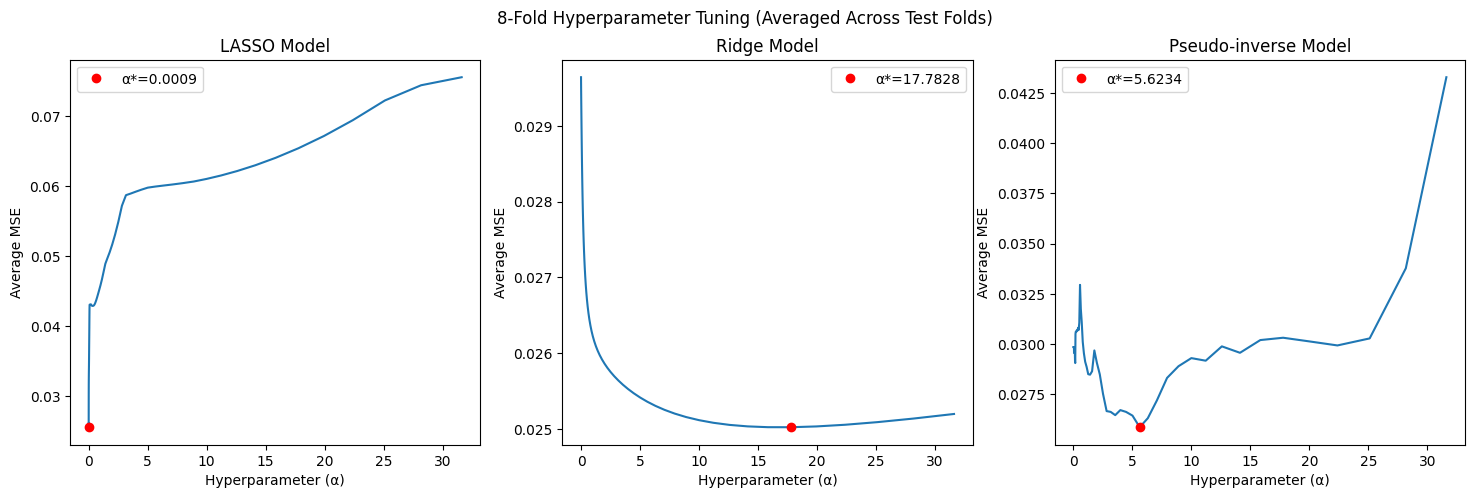

In [ ]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

fig.suptitle('8-Fold Hyperparameter Tuning (Averaged Across Test Folds)')

axs[0].set_title('LASSO Model')
axs[0].plot(param_range, avg_lasso_scores)
axs[0].plot(param_range[l_lasso_optimind], avg_lasso_scores[l_lasso_optimind], 'ro', label=f"α*={param_range[l_lasso_optimind]:.4f}")
axs[0].legend()
axs[0].set_xlabel('Hyperparameter (α)')
axs[0].set_ylabel('Average MSE')

axs[1].set_title('Ridge Model')
axs[1].plot(param_range, avg_ridge_scores)
axs[1].plot(param_range[l_ridge_optimind], avg_ridge_scores[l_ridge_optimind], 'ro', label=f"α*={param_range[l_ridge_optimind]:.4f}")
axs[1].legend()
axs[1].set_xlabel('Hyperparameter (α)')
axs[1].set_ylabel('Average MSE')

axs[2].set_title('Pseudo-inverse Model')
axs[2].plot(param_range, avg_pinv_scores)
axs[2].plot(param_range[l_pinv_optimind], avg_pinv_scores[l_pinv_optimind], 'ro', label=f"α*={param_range[l_pinv_optimind]:.4f}")
axs[2].legend()
axs[2].set_xlabel('Hyperparameter (α)')
axs[2].set_ylabel('Average MSE')

In [ ]:
# Evaluating optimal models
def eval_models(model):
    model.fit(Xfull_train, yfull_train)

    sig_coeffs = np.nonzero(model.coef_)[0]

    yhat_train = model.predict(Xfull_train)
    yhat_test = model.predict(Xfull_test)
    mse_is = mean_squared_error(yfull_train, yhat_train)
    mse_os = mean_squared_error(yfull_test, yhat_test)
    r2_is = r2_score(yfull_train, yhat_train)
    r2_os = r2_score(yfull_test, yhat_test)

    performance_dict = {
        'MSE (in-sample)': mse_is,
        'MSE (out-of-sample)': mse_os,
        'R2 (in-sample)': r2_is,
        'R2 (out-of-sample)': r2_os,
        'Nonzero Coefficients': len(sig_coeffs)
    }

    return performance_dict

lasso_performance = eval_models(Lasso(param_range[l_lasso_optimind], fit_intercept=True))
ridge_performance = eval_models(Ridge(param_range[l_ridge_optimind], fit_intercept=True))
pinv_performance = eval_models(Pinv(param_range[l_pinv_optimind])) # Note that the nonzero coefficients for this model include the intercept
lm3a_performance = eval_models(LinearRegression(fit_intercept=True))
lm2b_performance = {
    'MSE (in-sample)': mse2b_train,
    'MSE (out-of-sample)': mse2b_test,
    'R2 (in-sample)': r22b_train,
    'R2 (out-of-sample)': r22b_test,
    'Nonzero Coefficients': len(np.nonzero(lm_2b.coef_)[0])
}

table_df = pd.DataFrame([
    lasso_performance, ridge_performance, pinv_performance, lm3a_performance, lm2b_performance
    ],
    index=["LASSO", "Ridge", "Pseudoinverse", "3a Model", "2b Model"])
table_df

,MSE (in-sample),MSE (out-of-sample),R2 (in-sample),R2 (out-of-sample),Nonzero Coefficients
LASSO,0.013639,0.014037,0.911980,0.917348,88
Ridge,0.013816,0.014656,0.910842,0.913702,300
Pseudoinverse,0.016224,0.017376,0.895301,0.897689,302
3a Model,0.008446,0.017703,0.945497,0.895761,301
2b Model,0.022483,0.018819,0.854913,0.889191,36


We use these metrics to compare the models to those seen in 2(b) and 3(a). We see that across the board the models trained on the complete feature space outperform the simply numeric feature model, meaning that the categorical variables do contain information with predictive power on the transformed SalePrice variable. Between these complete models, we see that on in-sample metrics, the 3(a) model performs the best, followed by the LASSO and Ridge models (although the performance between these is very close). Despite this, to assess the performance of the model we are largely concerned with out-of-sample performance, in which case the 3(a) model performs the worst out of the complete-feature models. This is the value in regularization, which penalizes excessive complexity in the model learned during training that can lead to overfitting. As a result, these regularized models are generally able to extract more robust features.

## **Part c**
The table above shows the nonzero coefficients associated with each model. We note that the count for the pseudoinverse model includes the estimated intercept, and so for comparison we work with a nonzero coefficient count of $301$. Regardless, we see that the LASSO has by far the least number of nonzero coefficients, eliminating more than $70%$ of the feature variables in the model. This is a standard feature of LASSO regression due to the use of the L1 norm in the loss function. This metric promotes sparsity in the estimator, forcing the coefficients of superfluous features to zero due to the linearity in the penalty. This is compared to the L2 norm used in Ridge regression which in general only shrinks coefficients toward zero. This is why the LASSO is often used as a form of automatic feature selection.

## **Part d**
To determine model recommendation we consider both the performance and practicality of the models evaluated in the table above. On out-of-sample performance alone (and therefore the predictive power of the model), as stated above the LASSO and Ridge models trained on the complete feature set perform neck-and-neck, however the pseudoinverse model performs adequately as well. We would discourage the use of the 3(a) model due to possible problems with overfitting.

In regards to the 2(b) model, this could offer a light-weight option with decent out-of-sample performance. Practically this could be useful in light of either constrained computational resources or just model simplicity. With this consideration in mind, however, we recommend the LASSO as the best overall model as we believe this model balances the performance gains of the enriched feature set with the model simplicity of a sparse $\boldsymbol{\hat{\beta}}$. In this way the LASSO "intelligently" chooses which variables to include in the model to determine the optimal "bang for the buck."